In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torchinfo import summary

from exercise_code.data.segmentation_dataset import SegmentationData, label_img_to_rgb
from exercise_code.data.download_utils import download_dataset
from exercise_code.util import visualizer, save_model
from exercise_code.util.Util import checkSize, checkParams, test
from exercise_code.networks.my_segmentation_nn import SegmentationNN, AutoEnc, Encoder
from exercise_code.tests import test_seg_nn
from copy import deepcopy
#set up default cuda device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent the kernel from dying.

In [2]:
download_url = 'https://i2dl.vc.in.tum.de/static/data/segmentation_data.zip'
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(i2dl_exercises_path, 'datasets','segmentation')


download_dataset(
    url=download_url,
    data_dir=data_root,
    dataset_zip_name='segmentation_data.zip',
    force_download=False,
)

train_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/train.txt')
val_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/val.txt')
test_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/test.txt')

In [3]:
enc=Encoder()
autoenc=AutoEnc(encoder=enc)
autoenc.eval()
with torch.no_grad():
    print(summary(autoenc, (1, 3, 240, 240), device="cpu"))
sum(p.numel() for p in autoenc.parameters())

Layer (type:depth-idx)                             Output Shape              Param #
AutoEnc                                            [1, 3, 240, 240]          --
├─Encoder: 1-1                                     [1, 256, 60, 60]          --
│    └─BackBone: 2-1                               [1, 256, 60, 60]          --
│    │    └─PreBlock: 3-1                          [1, 64, 120, 120]         9,536
│    │    └─Sequential: 3-2                        [1, 64, 120, 120]         147,968
│    │    └─Sequential: 3-3                        [1, 128, 60, 60]          525,568
│    │    └─StandardLayer: 3-4                     [1, 256, 60, 60]          328,704
│    └─ASPP: 2-2                                   [1, 256, 60, 60]          --
│    │    └─ModuleList: 3-5                        --                        2,493,440
│    │    └─Sequential: 3-6                        [1, 256, 60, 60]          393,728
├─Sequential: 1-2                                  [1, 3, 60, 60]            --
│    

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


4046723

In [4]:
model=SegmentationNN(encoder=enc)
model.eval()
with torch.no_grad():
    print(summary(model, (1, 3, 240, 240), device="cpu"))
sum(p.numel() for p in model.parameters())

Layer (type:depth-idx)                             Output Shape              Param #
SegmentationNN                                     [1, 23, 240, 240]         --
├─Encoder: 1-1                                     [1, 256, 60, 60]          --
│    └─BackBone: 2-1                               [1, 256, 60, 60]          --
│    │    └─PreBlock: 3-1                          [1, 64, 120, 120]         9,536
│    │    └─Sequential: 3-2                        [1, 64, 120, 120]         147,968
│    │    └─Sequential: 3-3                        [1, 128, 60, 60]          525,568
│    │    └─StandardLayer: 3-4                     [1, 256, 60, 60]          328,704
│    └─ASPP: 2-2                                   [1, 256, 60, 60]          --
│    │    └─ModuleList: 3-5                        --                        2,493,440
│    │    └─Sequential: 3-6                        [1, 256, 60, 60]          393,728
├─Sequential: 1-2                                  [1, 23, 60, 60]           --
│    

4495191

# 2 Train Autoencoder

In [5]:
class DuplicateDataset(SegmentationData):
    def __init__(self, labeled_dataset):
        self.labeled_dataset = labeled_dataset

    def __len__(self):
        return len(self.labeled_dataset)

    def __getitem__(self, idx):
        feature = self.labeled_dataset[idx][0]  # Get the feature vector
        return feature, feature     # Return the same value for feature and target

In [6]:
train_data_autoencoder=DuplicateDataset(train_data)
val_data_autoencoder=DuplicateDataset(val_data)

In [7]:
from exercise_code.solver import Solver
device = torch.device("mps")
autoenc.to(device)

train_loader=torch.utils.data.DataLoader(train_data_autoencoder, batch_size=15, shuffle=True, drop_last=False)
val_loader=torch.utils.data.DataLoader(val_data_autoencoder, batch_size=19, shuffle=False, drop_last=True)




In [8]:
hp_auto={
    "epochs": 30, 
    "lr": 1e-4,
    "device":"mps",
    'weight_decay': 0.001, 
    'step_size': 10, 
    'gamma': 0.8, 
    "loss_func":torch.nn.MSELoss(),
    "patience": 4,
    "patience_delta": 0.00,
    "batch_size": 19
    }

In [9]:
if os.path.isfile("./models/best_encoder.model"):
    best_encoder=torch.load("./models/best_encoder.model")
    best_model=torch.load("./models/best_autoenc.model")
else:
    solver=Solver(autoenc, train_loader, val_loader, hp_auto)
    solver.train(tqdm=True,**hp_auto)
    best_encoder=autoenc.encoder
    torch.save(best_encoder,"./models/best_encoder.model")
    torch.save(autoenc,"./models/best_autoenc.model")


Validation Epoch [19/30]: 100%|████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.39it/s, val_loss=0.01030192]


Stopping early at epoch 19!
Best val loss of current config:0.010209433734416962


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


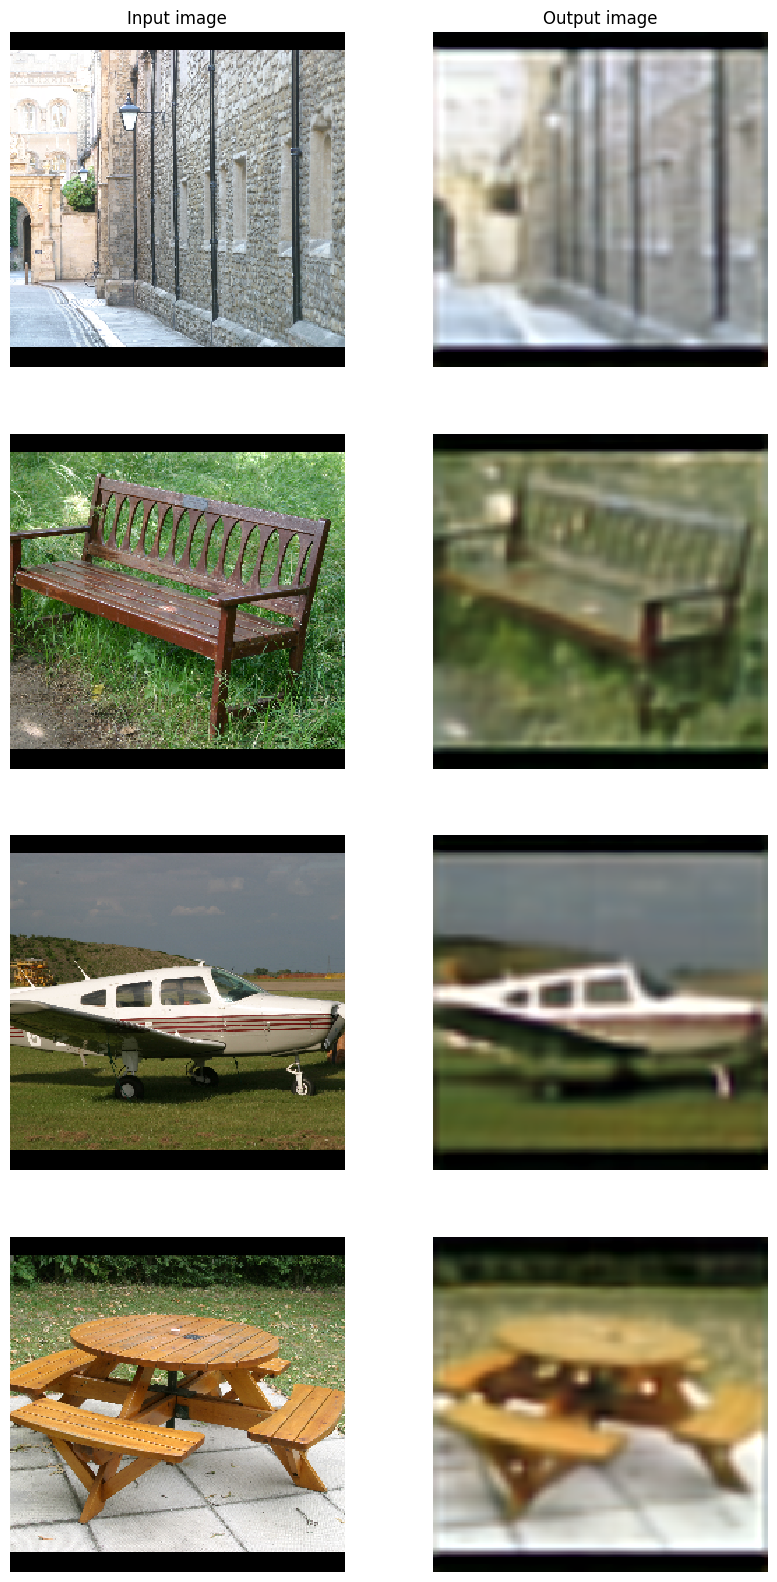

In [10]:
num_example_imgs=4
autoenc.eval()
with torch.no_grad():
    plt.figure(figsize=(10, 5 * num_example_imgs))
    for i in range(num_example_imgs):
        img=(test_data[i][0]).to(device)
        out=autoenc(img.unsqueeze(0))

        img = img.cpu()
        out = (out.squeeze(0)).cpu()
        img=img.numpy()
        out=out.numpy()
        

        # img
        plt.subplot(num_example_imgs, 2, i * 2 + 1)
        plt.axis('off')
        plt.imshow(img.transpose(1, 2, 0))
        if i == 0:
            plt.title("Input image")

        # target
        plt.subplot(num_example_imgs, 2, i * 2 + 2)
        plt.axis('off')
        plt.imshow(out.transpose(1, 2, 0))
        if i == 0:
            plt.title("Output image")

    plt.show()


# 3 Train Segmentation

In [10]:
########################################################################
# TODO - Train Your Model                                              #
########################################################################


 # One of the most crucial things in deep learning is to understand the training pipeline:
 # 1. Forward()          --> The forward pass of the network, to calculate the currnent loss.
 # 2. Backward()         --> The backward pass of the network, to calculate the gradients w.r.t the loss, calculated in the previous stage.
 # 3. Optimizer_step()   --> Update the weights w.r.t their corresponding gradients and the learnign rate.

device="mps"
train_loader=torch.utils.data.DataLoader(train_data, batch_size=15, shuffle=True, drop_last=False)
val_loader=torch.utils.data.DataLoader(val_data, batch_size=19, shuffle=False, drop_last=True)
optimizer = torch.optim.Adam(model.parameters(),lr=5*1e-4,weight_decay=0.01)
validation_loss = 0
epochs=30

class PretrainedModel(torch.nn.Module):
    def __init__(self, hp):
        super().__init__()
        self.model=SegmentationNN(encoder=torch.load("./models/best_encoder.model"))
        self.hp=hp
        self.set_optimizer()
        self.set_optimizer_scheduler()

    def forward(self,x):
        return self.model(x)

    def set_optimizer(self):
        self.optimizer=self.hp.get("optimizer",torch.optim.Adam)
        optim_params = self.optimizer.__init__.__code__.co_varnames[:self.optimizer.__init__.__code__.co_argcount]
        parsed_arguments={ key: value for key,value in self.hp.items() if key in optim_params}
        self.optimizer=self.optimizer(self.parameters(), **parsed_arguments)

    def set_optimizer_scheduler(self):
        self.scheduler=torch.optim.lr_scheduler.StepLR
        scheduler_params = torch.optim.lr_scheduler.StepLR.__init__.__code__.co_varnames[:torch.optim.lr_scheduler.StepLR.__init__.__code__.co_argcount]
        parsed_arguments={ key: value for key,value in self.hp.items() if key in scheduler_params}
        self.optimizer_scheduler=torch.optim.lr_scheduler.StepLR(self.optimizer ,**parsed_arguments)

In [12]:
hp={
    "epochs": 15, 
    "device":"mps",
    'weight_decay': 0.001, 
    'step_size': 10, 
    'gamma': 0.8, 
    "loss_func":torch.nn.CrossEntropyLoss(ignore_index=-1, reduction='mean'),
    "patience": 4,
    "patience_delta": 0.00,
    "batch_size": 19
    }

In [14]:
from exercise_code.hyperparameter_tuning import random_search
num_searches=5

new_config={
        "reg": ([1e-3, 1e-6], "log"),
        "lr": ([1e-3,1e-5], "log"),
        }

for key,value in hp.items():
    if key not in (new_config):
        new_config[key]=([value],"item")



best_model, best_config, results  = random_search(
    train_data, val_data,
    random_search_spaces = new_config,
    model=PretrainedModel,
    num_search = num_searches)


Evaluating Config #1 [of 5]:
 {'reg': 0.0005805282439976874, 'lr': 0.0004553259724033634, 'epochs': 15, 'device': 'mps', 'weight_decay': 0.001, 'step_size': 10, 'gamma': 0.8, 'loss_func': CrossEntropyLoss(), 'patience': 4, 'patience_delta': 0.0, 'batch_size': 19}


Validation Epoch [14/15]: 100%|████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.46it/s, val_loss=1.49873525]


Best val loss of current config:1.498735249042511

Evaluating Config #2 [of 5]:
 {'reg': 3.48060881059325e-05, 'lr': 0.00014471224334783187, 'epochs': 15, 'device': 'mps', 'weight_decay': 0.001, 'step_size': 10, 'gamma': 0.8, 'loss_func': CrossEntropyLoss(), 'patience': 4, 'patience_delta': 0.0, 'batch_size': 19}


Validation Epoch [14/15]: 100%|████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.68it/s, val_loss=1.94518864]


Best val loss of current config:1.9451886415481567

Evaluating Config #3 [of 5]:
 {'reg': 0.0005552418519193259, 'lr': 0.0004791316029732218, 'epochs': 15, 'device': 'mps', 'weight_decay': 0.001, 'step_size': 10, 'gamma': 0.8, 'loss_func': CrossEntropyLoss(), 'patience': 4, 'patience_delta': 0.0, 'batch_size': 19}


Validation Epoch [14/15]: 100%|████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.42it/s, val_loss=1.31282222]


Best val loss of current config:1.3128222227096558

Evaluating Config #4 [of 5]:
 {'reg': 3.3073409879960644e-06, 'lr': 5.091433429843988e-05, 'epochs': 15, 'device': 'mps', 'weight_decay': 0.001, 'step_size': 10, 'gamma': 0.8, 'loss_func': CrossEntropyLoss(), 'patience': 4, 'patience_delta': 0.0, 'batch_size': 19}


Validation Epoch [14/15]: 100%|████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.36it/s, val_loss=2.21703175]


Best val loss of current config:2.2170317471027374

Evaluating Config #5 [of 5]:
 {'reg': 3.5915721124017526e-05, 'lr': 0.00019535576973453756, 'epochs': 15, 'device': 'mps', 'weight_decay': 0.001, 'step_size': 10, 'gamma': 0.8, 'loss_func': CrossEntropyLoss(), 'patience': 4, 'patience_delta': 0.0, 'batch_size': 19}


Validation Epoch [14/15]: 100%|████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.50it/s, val_loss=1.69389910]


Best val loss of current config:1.6938990950584412

Search done. Best Val Loss = 1.3128222227096558
Best Config: {'reg': 0.0005552418519193259, 'lr': 0.0004791316029732218, 'epochs': 15, 'device': 'mps', 'weight_decay': 0.001, 'step_size': 10, 'gamma': 0.8, 'loss_func': CrossEntropyLoss(), 'patience': 4, 'patience_delta': 0.0, 'batch_size': 19}


In [20]:
from torch.utils.data import DataLoader
from exercise_code.solver import Solver
hp=best_config
hp["epochs"]=50
hp["step_size"]=5
train_loader=DataLoader(train_data, batch_size=hp["batch_size"], shuffle=True)
val_loader=DataLoader(val_data, batch_size=hp["batch_size"], shuffle=False)
solver=Solver(best_model,train_loader,val_loader,hparams=hp)
solver.train(tqdm=True,**hp)

Validation Epoch [4/50]: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.76it/s, val_loss=0.87996113]

Stopping early at epoch 4!
Best val loss of current config:0.8697703927755356


In [21]:
model=best_model
model.to(torch.device('cpu'))
device = torch.device('cpu')
def evaluate_model(model, dataloader):
    test_scores = []
    model.eval()
    model = model.to(device)
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model.forward(inputs)
        _, preds = torch.max(outputs, 1)
        targets_mask = (targets >= 0).cpu()
        test_scores.append(np.mean((preds.cpu() == targets.cpu())[targets_mask].numpy()))

    return np.mean(test_scores)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=False,num_workers=0)
test(evaluate_model(model, test_loader))


Validation-Accuracy: 64.7061130825638%
Congrats! The accuracy passes the threshold, you can try to submit your model to server now.


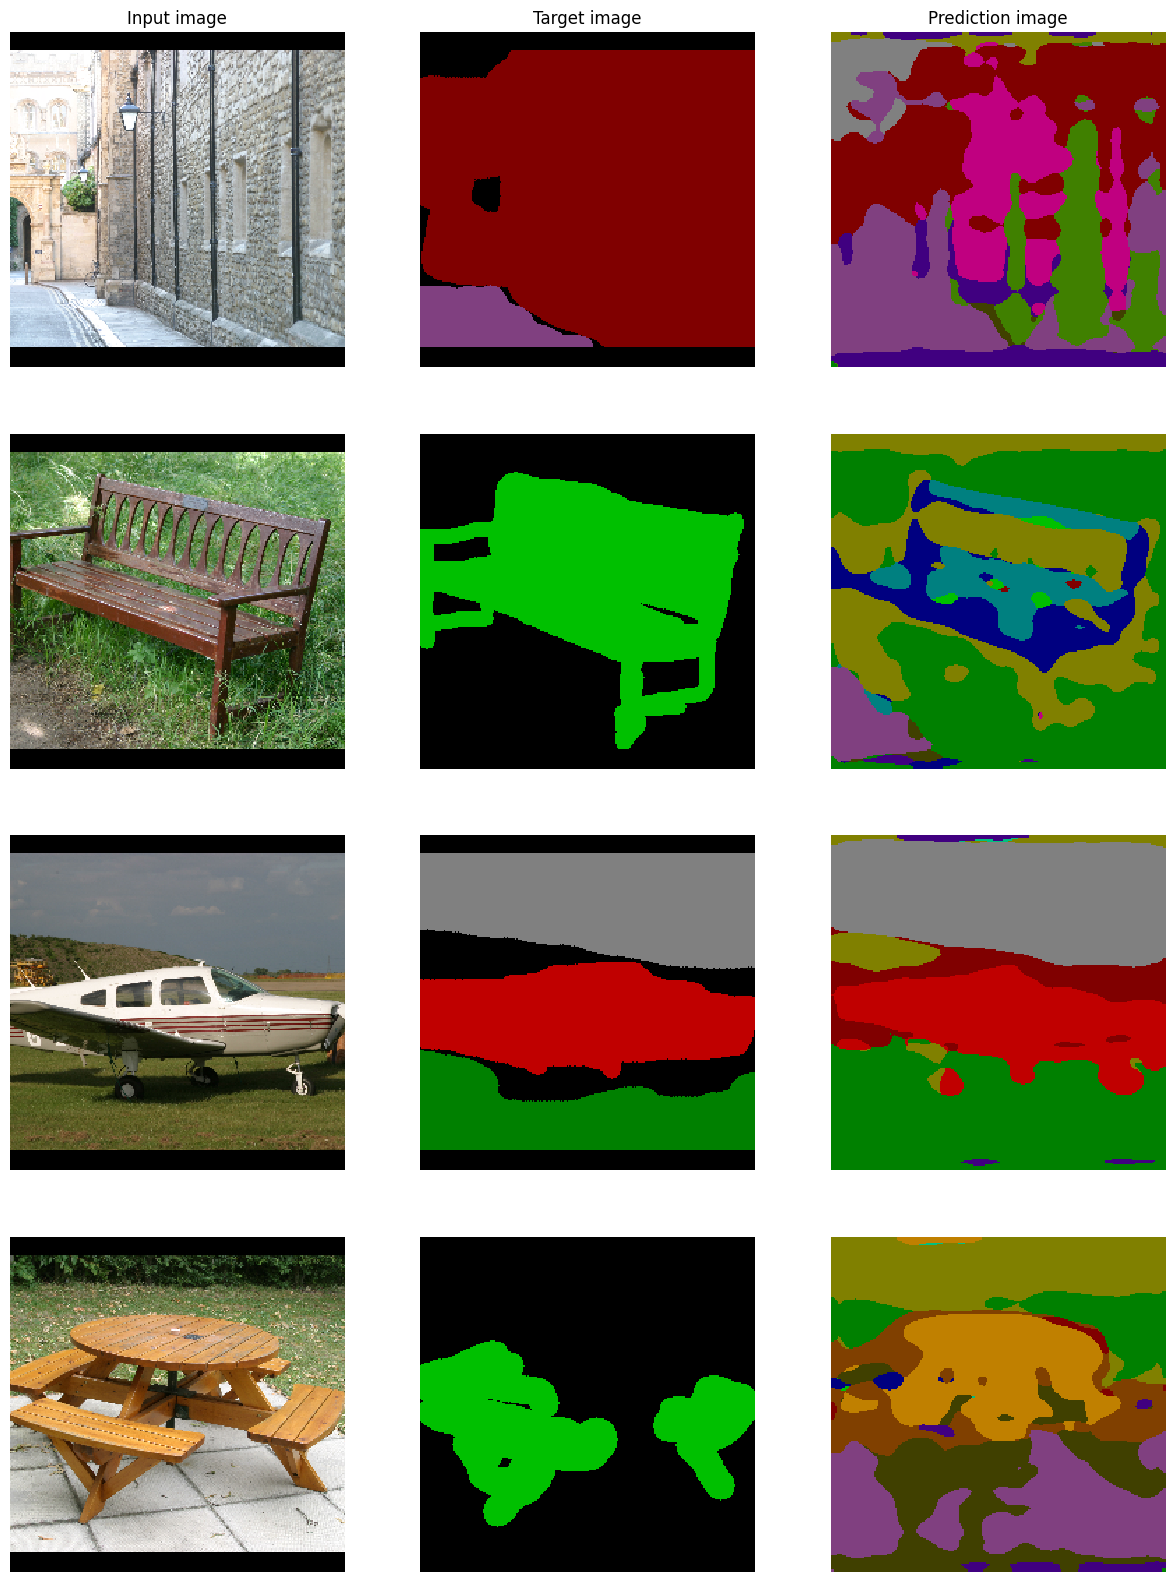

In [22]:
visualizer(model, test_data)